<a href="https://colab.research.google.com/github/elifsare/Website-Classification/blob/main/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Website Classification
* Bu çalışma birçok farklı kategoriye ayrılmış web sitesi içeriği ve class değeri içermektedir.

* Text içeriğini kullanarak çeşitli machine learning modelleri, deep learning modeli(LSTM) ve transformer mimarisi (BERT) kullanılarak, sınıflandırma yapan tahmin modelleri eğitilmiştir.

* Eğitilen her model analiz edilmiş, görselleştirilmiştir.

Veri seti kaggle'dan alınmıştır: https://www.kaggle.com/datasets/hetulmehta/website-classification/data?select=website_classification.csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Librariers


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler

!pip install torch torchvision torchaudio
import torch


# Data Analysis and Visualization

Get Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/toruk MAGIC/dataset/website_classification.csv')

In [ ]:
data.head()

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            1408 non-null   int64 
 1   website_url           1408 non-null   object
 2   cleaned_website_text  1408 non-null   object
 3   Category              1408 non-null   object
dtypes: int64(1), object(3)
memory usage: 44.1+ KB


In [ ]:
data['Category'].value_counts()

,count
Category,
Education,114
Business/Corporate,109
Travel,107
Streaming Services,105
Sports,104
E-Commerce,102
Games,98
News,96
Health and Fitness,96


In [ ]:
data.isna().sum()

,0
Unnamed: 0,0
website_url,0
cleaned_website_text,0
Category,0


In [ ]:
data['cleaned_website_text'].duplicated().sum()

33

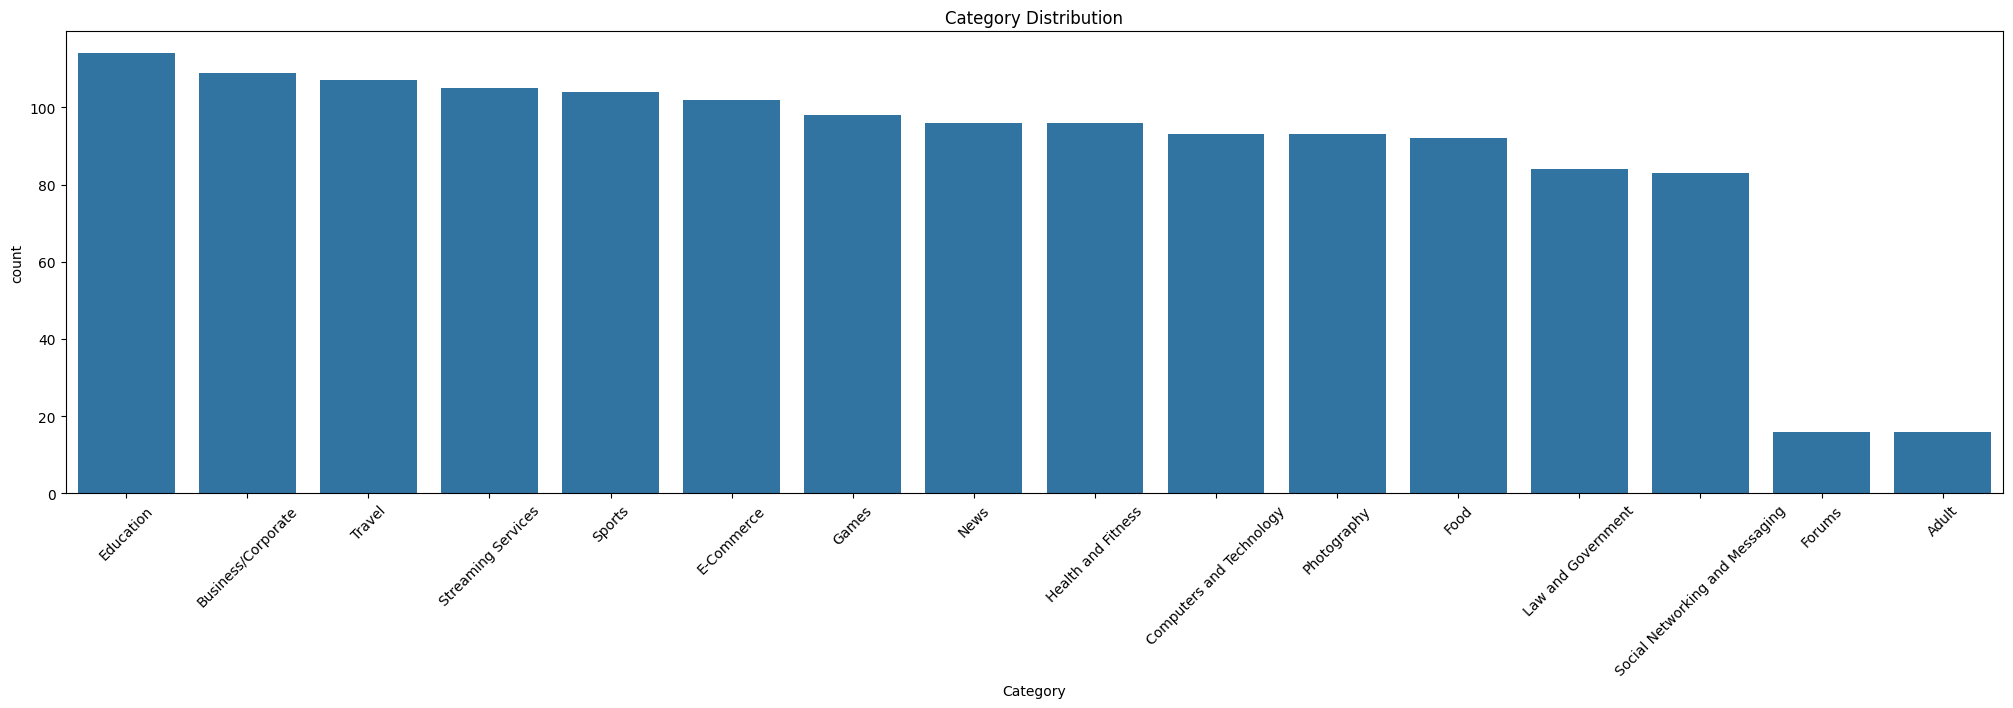

In [ ]:
plt.figure(figsize=(25, 6))
sns.countplot(data=data, x='Category', order=data['Category'].value_counts().index)
plt.title('Category Distribution')
plt.xticks(rotation=45)
plt.show()

# Data Processing

In [ ]:
data = data.drop(columns=['Unnamed: 0', 'website_url'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   cleaned_website_text  1408 non-null   object
 1   Category              1408 non-null   object
dtypes: object(2)
memory usage: 22.1+ KB


In [ ]:
data.drop_duplicates(subset=['cleaned_website_text'], inplace=True)

In [ ]:
data['cleaned_website_text'].duplicated().sum()

0

In [ ]:
label_encoder = LabelEncoder()
data['Category'] = label_encoder.fit_transform(data['Category'])

# ML models

##  Data Processing for ML models

In [ ]:
ml_data = data.copy()

In [ ]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(ml_data['cleaned_website_text'])
y = ml_data['Category']

## Model Train, Evulation, Visulation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(),
    'Naive Bayes': MultinomialNB()
}

results = {}

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Training: Random Forest
Random Forest Accuracy: 0.83
Classification Report:
                                 precision    recall  f1-score   support

                         Travel       1.00      0.20      0.33         5
Social Networking and Messaging       0.68      0.79      0.73        19
                           News       0.57      0.62      0.59        13
             Streaming Services       0.85      0.88      0.87        26
                         Sports       0.79      0.90      0.84        21
                    Photography       0.96      0.85      0.90        26
             Law and Government       0.00      0.00      0.00         3
             Health and Fitness       0.88      0.88      0.88        17
                          Games       1.00      0.93      0.97        15
                     E-Commerce       0.92      0.92      0.92        24
                         Forums       0.89      0.84      0.86        19
                           Food       0.72     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


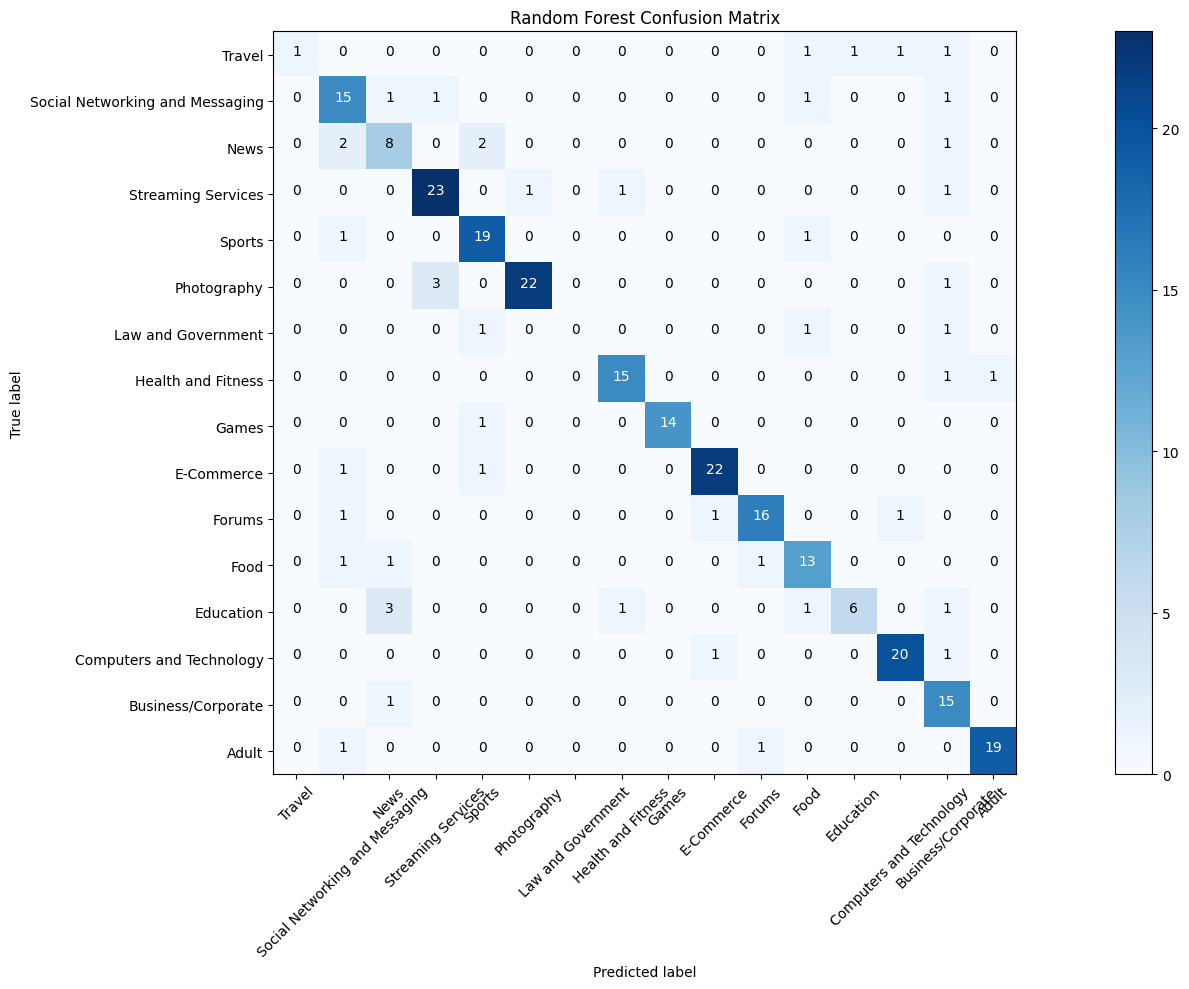


---

Training: Logistic Regression
Logistic Regression Accuracy: 0.89
Classification Report:
                                 precision    recall  f1-score   support

                         Travel       1.00      0.20      0.33         5
Social Networking and Messaging       0.71      0.89      0.79        19
                           News       0.69      0.85      0.76        13
             Streaming Services       0.92      0.92      0.92        26
                         Sports       0.88      1.00      0.93        21
                    Photography       0.93      0.96      0.94        26
             Law and Government       0.00      0.00      0.00         3
             Health and Fitness       0.89      0.94      0.91        17
                          Games       0.93      0.93      0.93        15
                     E-Commerce       1.00      0.96      0.98        24
                         Forums       0.85      0.89      0.87        19
                           Fo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


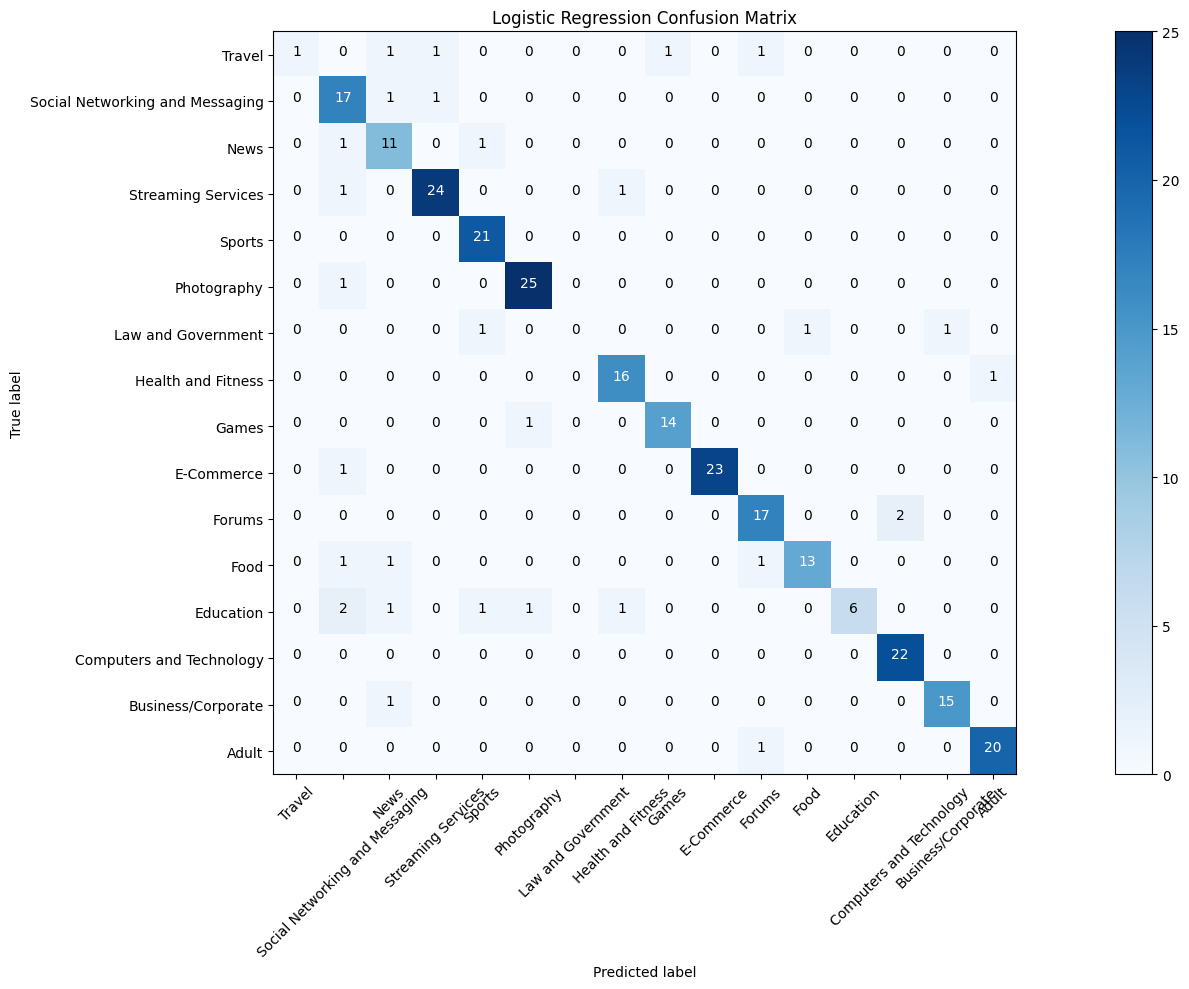


---

Training: Support Vector Machine
Support Vector Machine Accuracy: 0.83
Classification Report:
                                 precision    recall  f1-score   support

                         Travel       1.00      0.20      0.33         5
Social Networking and Messaging       0.38      0.95      0.55        19
                           News       0.69      0.85      0.76        13
             Streaming Services       0.96      0.85      0.90        26
                         Sports       0.87      0.95      0.91        21
                    Photography       0.96      0.85      0.90        26
             Law and Government       0.00      0.00      0.00         3
             Health and Fitness       0.87      0.76      0.81        17
                          Games       1.00      0.93      0.97        15
                     E-Commerce       1.00      0.92      0.96        24
                         Forums       0.84      0.84      0.84        19
                       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


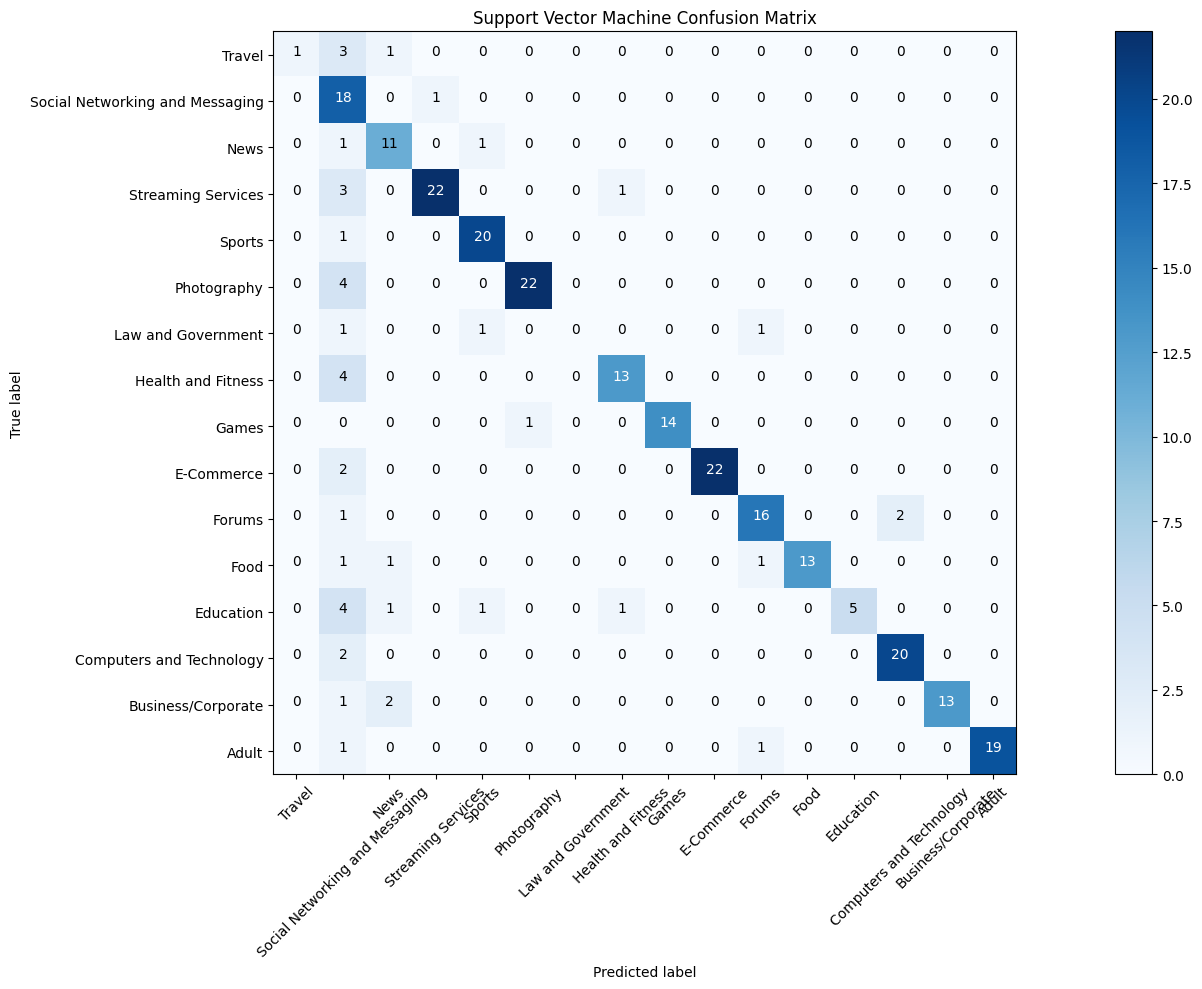


---

Training: Naive Bayes
Naive Bayes Accuracy: 0.88
Classification Report:
                                 precision    recall  f1-score   support

                         Travel       0.00      0.00      0.00         5
Social Networking and Messaging       0.89      0.84      0.86        19
                           News       0.90      0.69      0.78        13
             Streaming Services       0.96      0.88      0.92        26
                         Sports       0.81      1.00      0.89        21
                    Photography       0.93      0.96      0.94        26
             Law and Government       0.00      0.00      0.00         3
             Health and Fitness       0.89      0.94      0.91        17
                          Games       1.00      0.87      0.93        15
                     E-Commerce       1.00      1.00      1.00        24
                         Forums       0.72      0.95      0.82        19
                           Food       0.87   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


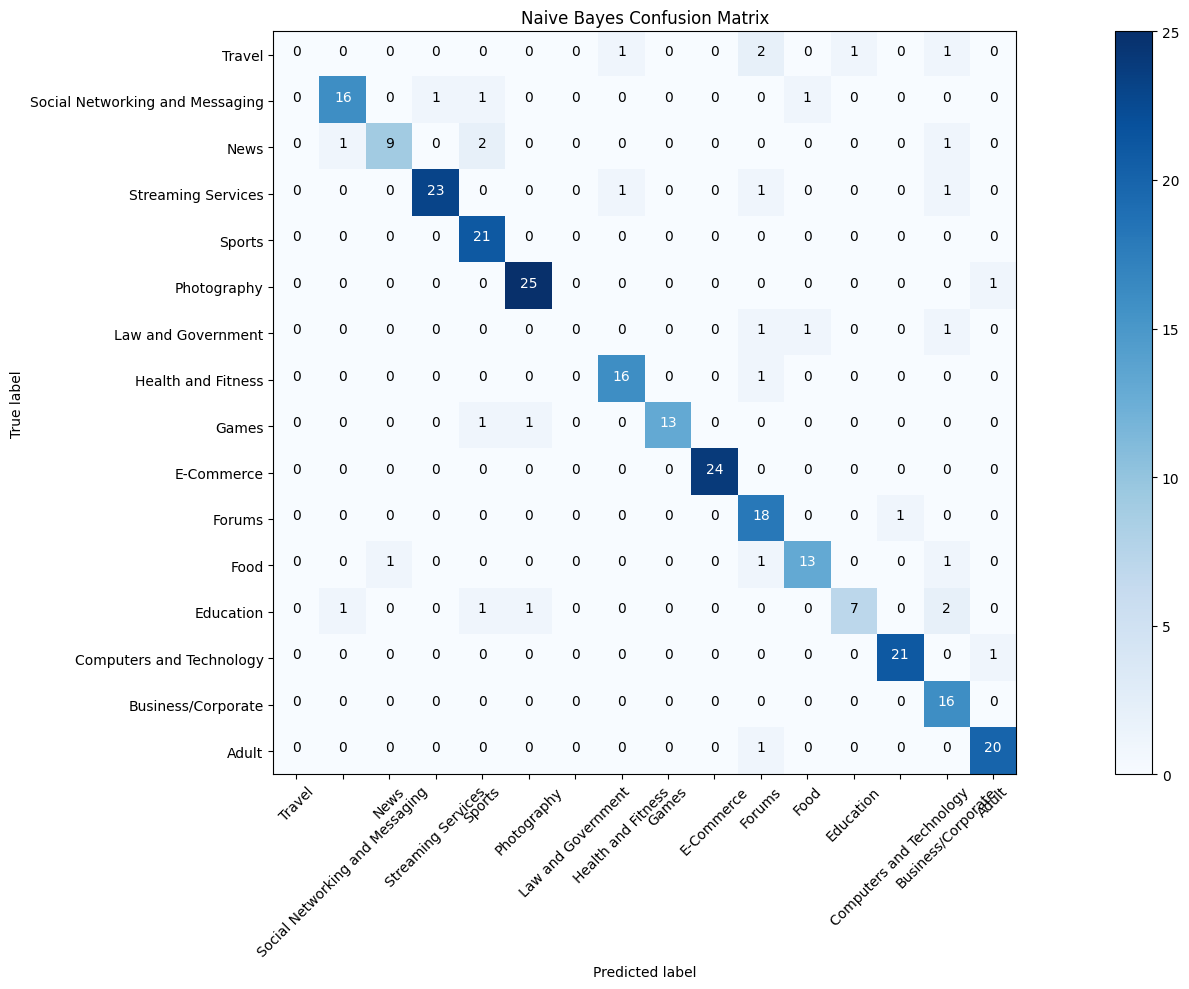


---



In [ ]:
for model_name, model in models.items():
    print(f"Training: {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {acc:.2f}")

    results[model_name] = acc

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=categories))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=categories, title=f"{model_name} Confusion Matrix")
    plt.show()
    print("\n---\n")

## Comparison of accuracy value

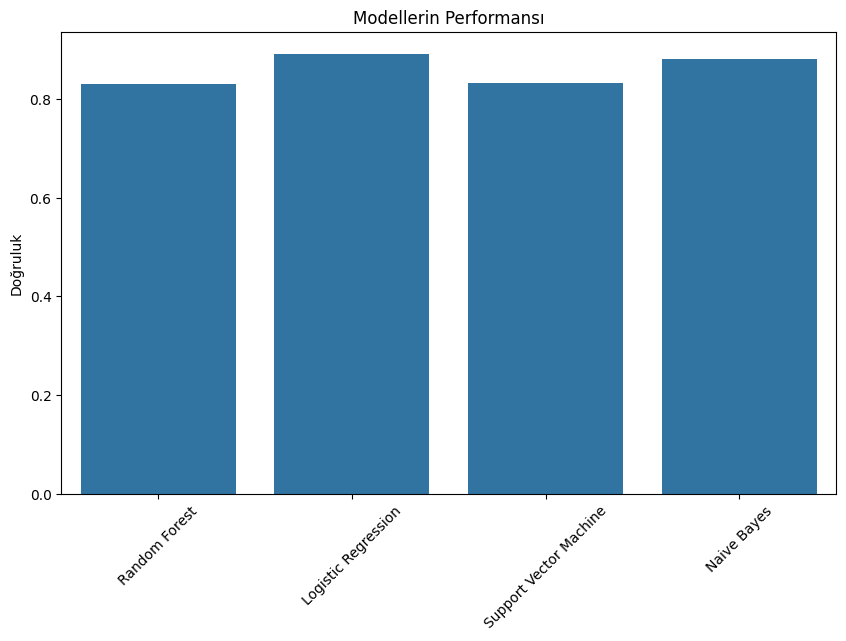

In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Modellerin Performansı')
plt.ylabel('Doğruluk')
plt.xticks(rotation=45)
plt.show()

# LSTM
Modelde, sıralı verileri işlemek için Bidirectional LSTM (iki yönlü LSTM) katmanları bulunmaktadır. CNN yerine LSTM kullanılmıştır çünkü bu tür sıralı verilerde (metin verisi gibi) LSTM modelleri zaman içindeki bağımlılıkları yakalamakta oldukça başarılıdır.

Özellikle şu katmanlara dikkat çekebiliriz:
* Embedding Katmanı: Metin verilerini yoğun (dense) bir vektör temsilinde işler.
* Bidirectional LSTM: İleri ve geri yönde bilgi taşıyarak sıralı verilerde daha iyi bir bağlam anlayışı sağlar.
* Dropout: Overfitting'i önlemek için rastgele bazı nöronları sıfırlar.
* Dense Katman: Son sınıflandırma katmanıdır ve softmax aktivasyon fonksiyonu ile çok sınıflı bir olasılık dağılımı sağlar.

## Data Processing for LSTM

In [ ]:
lstm_data = data.copy()

In [ ]:
# Tokenizer ve Padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(lstm_data['cleaned_website_text'])

sequences = tokenizer.texts_to_sequences(lstm_data['cleaned_website_text'])
X = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')
y = lstm_data['Category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=200),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(categories), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.0919 - loss: 2.7562 - val_accuracy: 0.1127 - val_loss: 2.7214
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1293 - loss: 2.6226 - val_accuracy: 0.1564 - val_loss: 2.5519
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2025 - loss: 2.3790 - val_accuracy: 0.2727 - val_loss: 2.3002
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4450 - loss: 1.9608 - val_accuracy: 0.3855 - val_loss: 1.9462
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5549 - loss: 1.5137 - val_accuracy: 0.4509 - val_loss: 1.7724
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7120 - loss: 1.1620 - val_accuracy: 0.5564 - val_loss: 1.5221
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7991 - loss: 0.9160 - val_accuracy: 0.5709 - val_loss: 1.4675
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8403 - loss: 0.7226 - val_accuracy: 0.5527 - v

In [ ]:
# Performans Değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Doğruluğu: {accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5867 - loss: 1.4105
Test Doğruluğu: 0.60


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


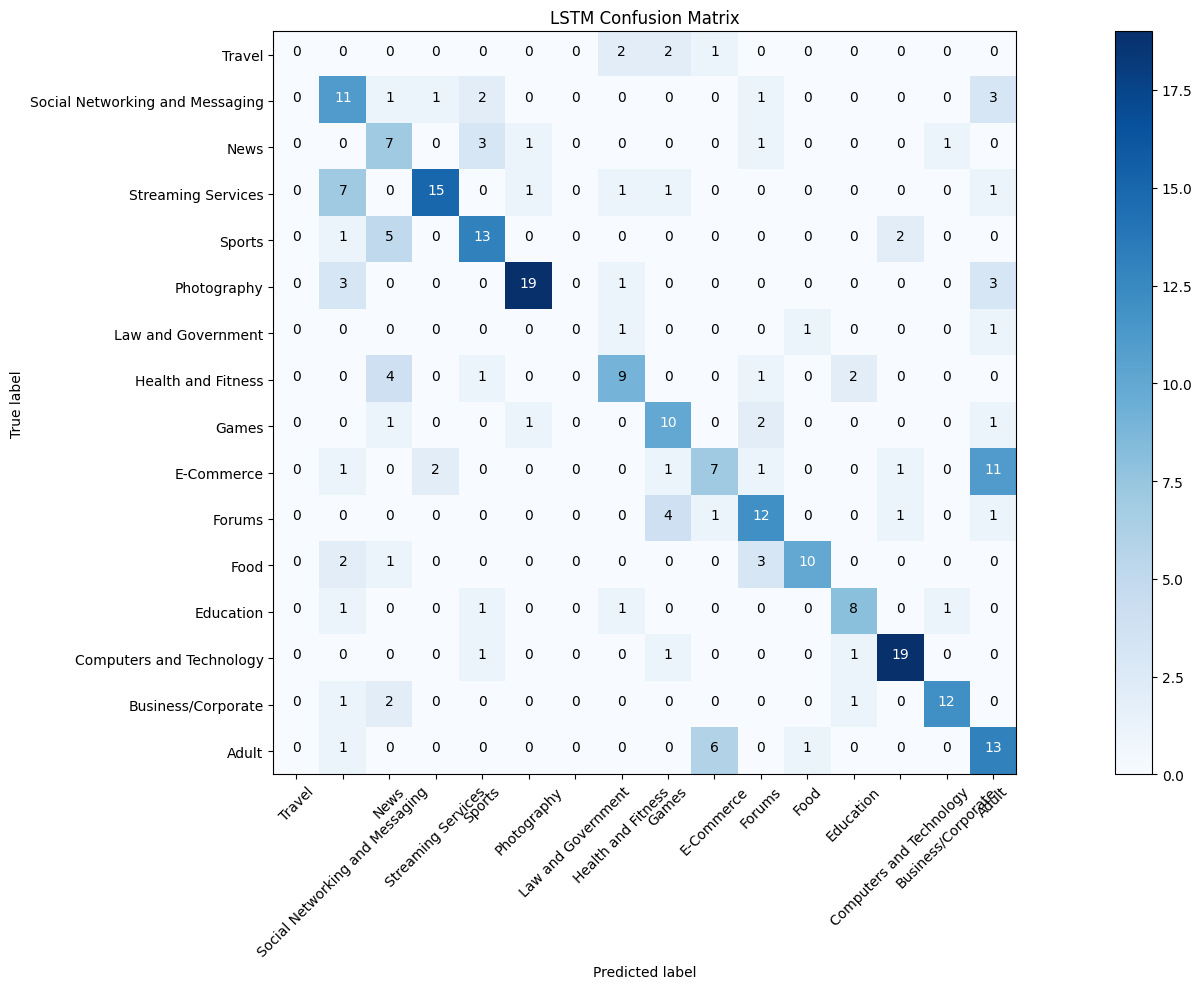

In [ ]:
# Confusion Matrix Görselleştirme
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(20, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

y_pred = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=categories, title="LSTM Confusion Matrix")
plt.show()



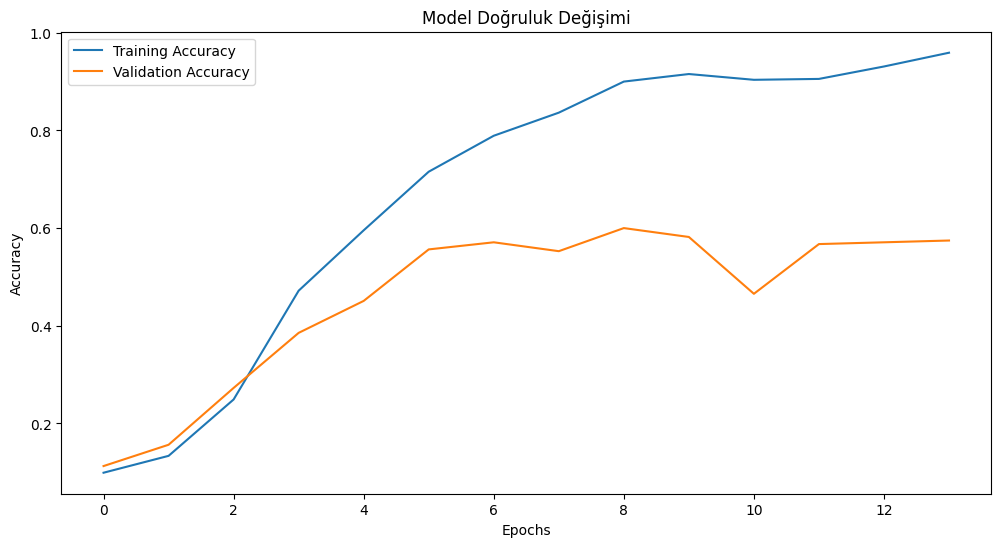

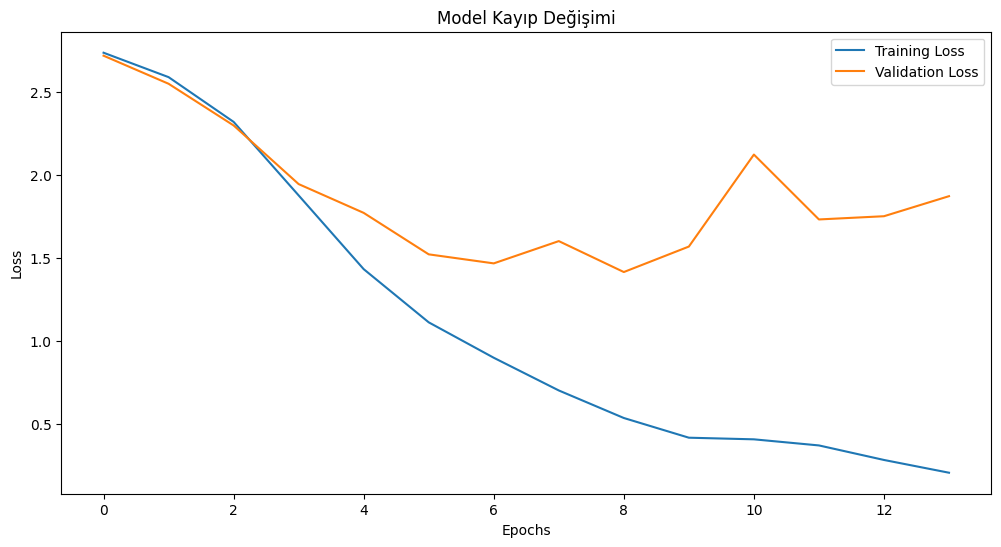

In [ ]:

# Eğitim Süreci Görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Doğruluk Değişimi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Kayıp Değişimi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# BERT Model

In [ ]:
bert_data = data.copy()

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(bert_data['cleaned_website_text'].values,
                                                                    bert_data['Category'].values,
                                                                    test_size=0.2,
                                                                    random_state=42)

In [ ]:
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizer function
def encode_texts(texts, tokenizer, max_len=512):
    encoded_texts = [tokenizer(text, truncation=True, padding='max_length', max_length=max_len, return_tensors="pt") for text in texts]
    input_ids = torch.cat([et['input_ids'] for et in encoded_texts])
    attention_masks = torch.cat([et['attention_mask'] for et in encoded_texts])
    return input_ids, attention_masks

# Eğitim ve doğrulama verilerini tokenize etme
train_input_ids, train_attention_masks = encode_texts(train_texts, tokenizer)
val_input_ids, val_attention_masks = encode_texts(val_texts, tokenizer)


In [ ]:
# Tensor Dataset
train_dataset = torch.utils.data.TensorDataset(train_input_ids, train_attention_masks, torch.tensor(train_labels))
val_dataset = torch.utils.data.TensorDataset(val_input_ids, val_attention_masks, torch.tensor(val_labels))

In [ ]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
# Load BERT base model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimization and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
loss_fn = torch.nn.CrossEntropyLoss()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in data_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy


def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [ ]:
num_epochs = 5
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1/5
Train Loss: 2.0575, Train Accuracy: 0.4509
Val Loss: 0.9092, Val Accuracy: 0.8691
Epoch 2/5
Train Loss: 0.5468, Train Accuracy: 0.9145
Val Loss: 0.4533, Val Accuracy: 0.8945
Epoch 3/5
Train Loss: 0.2470, Train Accuracy: 0.9555
Val Loss: 0.3815, Val Accuracy: 0.9127
Epoch 4/5
Train Loss: 0.1602, Train Accuracy: 0.9718
Val Loss: 0.3991, Val Accuracy: 0.9127
Epoch 5/5
Train Loss: 0.1008, Train Accuracy: 0.9791
Val Loss: 0.3265, Val Accuracy: 0.9309


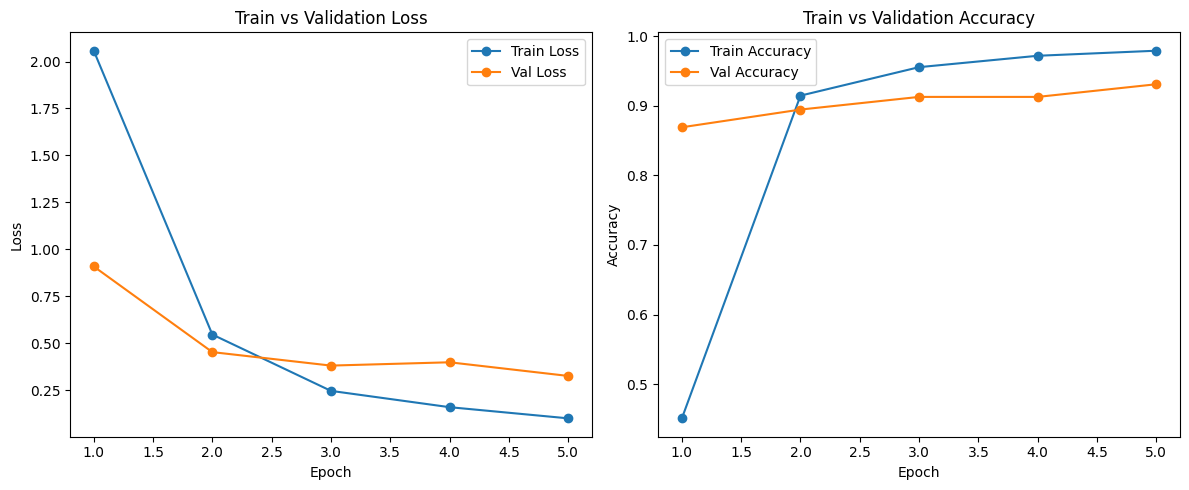

In [ ]:
# Train/Test Loss ve Accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Val Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', label='Val Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
